In [1]:
import os
import pandas as pd
import numpy as np
import scipy.sparse as sp
import json
import random
import regex
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time
"""
This script trains a MLP classifier to predict the binding affinity of a 30 bases sequence w.r.t. the obtained priming window.

The training data is obtained from the upstream 30 bases of the alignments of R1 in our paired-end read alignment results from the genome. The training data has the same orientation as its read2, so, it should contain a polyA site.
As reads might come from polyA tails, which are not included in the genome, we would expect that some of the input data come from intergenic regions and do not correspond to a polyA site. This is saying our labels are noisy, so we would not expect to obtain perfect accuracy.

We train a MLP classifier by reading the training data from each SRR and call `partial_fit` to update the model. 

"""

parser = json.load(open("params.json", "r"))
parent_dir = parser["parent_dir"]
PE_sheet = parser["PE_sheet"]
random_seed = parser["random_seed"]
outdir= parser["outdir"]
snr_len = parser["snr_len"]
snr_mismatch = parser["snr_mismatch"]

print(parser)
os.makedirs(outdir, exist_ok=True)

{'parent_dir': 'workflow_output', 'PE_sheet': 'sample_url_sheet.csv', 'outdir': 'mlp_model', 'random_seed': 10, 'snr_len': 6, 'snr_mismatch': 1}


In [2]:

encoder = OneHotEncoder(categories=[['A', 'C', 'G', 'T', 'N']] * 30, handle_unknown='ignore')

parent_dir = parent_dir
# 1----- Get the PE datasets spreadsheet
PE_sheet = pd.read_csv(PE_sheet)

# 2----- loop through GSE(s), combine all tlen from its SRR
# check if we have all datasets processed
missing_files = []

for (GSE, group_gse_lst) in PE_sheet.groupby('GSE'):
    SRR_lst = group_gse_lst['SRR']
    for SRR in SRR_lst:
        polya_path = os.path.join(
            parent_dir, "process_data", "frag_len_dist", GSE, SRR, "priming_site_seqs", "polya_seq.txt")

        if os.path.exists(polya_path):
            check_file = os.path.getsize(polya_path)
            if (check_file == 0):
                missing_files.append(f"{GSE}-{SRR}")
                error_occur = True
        else:
            missing_files.append(f"{GSE}-{SRR}")
            error_occur = True

if missing_files:
    raise ValueError(f"Please re-run the previous step, the output of following dataset(s) is either missing or empty: {missing_files}")


GSE122357
GSE122743
GSE125188


GSE125970
GSE130636


GSE131736
GSE134520


GSE135922


GSE144136
GSE148504


Iteration 1, loss = 0.66836542
Accuracy: 0.6885245901639344


Iteration 1, loss = 0.53811119
Accuracy: 0.8040691608287375


Iteration 1, loss = 0.46762592
Accuracy: 0.8008217993079585


Iteration 1, loss = 0.42007161
Accuracy: 0.8360879231511389


Iteration 1, loss = 0.34802308
Accuracy: 0.8680899054251909


Iteration 1, loss = 0.30050789
Accuracy: 0.8887649683024184


Iteration 1, loss = 0.28585845
Accuracy: 0.8996074879227053


Iteration 1, loss = 0.29762550
Accuracy: 0.8932374100719425


Iteration 1, loss = 0.28604958
Accuracy: 0.8973229673317759


Iteration 1, loss = 0.29168309
Accuracy: 0.886648270006368


Iteration 1, loss = 0.28862218
Accuracy: 0.8990558545839583


Iteration 1, loss = 0.28575475
Accuracy: 0.9013401888064734


Iteration 1, loss = 0.27720466
Accuracy: 0.9054488652026096
Iteration 1, loss = 0.29016659
Accuracy: 0.8991304347826087


Iteration 1, loss = 0.27276763


Accuracy: 0.8995526095662975


Iteration 1, loss = 0.26871747


Accuracy: 0.9002298898329144


Iteration 1, loss = 0.26001939


Accuracy: 0.9092819718980709


Iteration 1, loss = 0.25963096


Accuracy: 0.9130110453855416


Iteration 1, loss = 0.24774604


Accuracy: 0.9174573055028463


Iteration 1, loss = 0.24624450


Accuracy: 0.9160999554874129
Iteration 1, loss = 0.33223185
Accuracy: 0.8893156424581006


Iteration 1, loss = 0.30828171
Accuracy: 0.8993633692458374
Iteration 1, loss = 0.30991553
Accuracy: 0.9024539877300614


Iteration 1, loss = 0.29135955
Accuracy: 0.9009406231628454
Iteration 1, loss = 0.28475729
Accuracy: 0.9008955223880597


Iteration 1, loss = 0.31054901
Accuracy: 0.8998357963875205
Iteration 1, loss = 0.34461553
Accuracy: 0.8806552262090483


Iteration 1, loss = 0.29661525
Accuracy: 0.9046164290563475
Iteration 1, loss = 0.29251975


Accuracy: 0.9069703622392975
Iteration 1, loss = 0.31284408
Accuracy: 0.8918918918918919


Iteration 1, loss = 0.29449196
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9070203644158628
Iteration 1, loss = 0.27926270
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9046610169491526


Iteration 1, loss = 0.30034225
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9010416666666666
Iteration 1, loss = 0.29130017
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9045424621461488


Iteration 1, loss = 0.29905171
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8993943472409152
Iteration 1, loss = 0.29334260
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9046653144016227


Iteration 1, loss = 0.31738109
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8874107722258274
Iteration 1, loss = 0.29947587
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8957858769931663


Iteration 1, loss = 0.29799442
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9007263922518159
Iteration 1, loss = 0.28807178
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Accuracy: 0.9050701186623517
Iteration 1, loss = 0.31612564
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.884375


Iteration 1, loss = 0.29667593
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8872611464968153
Iteration 1, loss = 0.30195939
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.894646533973919


Iteration 1, loss = 0.33246226
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8927556818181818
Iteration 1, loss = 0.28822816
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9041614123581336


Iteration 1, loss = 0.31564161
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8821138211382114
Iteration 1, loss = 0.29022746
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9069264069264069


Iteration 1, loss = 0.28459580
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.90788662969809
Iteration 1, loss = 0.31163278
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8951858622790981


Iteration 1, loss = 0.28736459
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9044648719632304
Iteration 1, loss = 0.30217838
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.897196261682243


Iteration 1, loss = 0.31387909
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8939393939393939
Iteration 1, loss = 0.29045637
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9059328649492584


Iteration 1, loss = 0.32394746
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8803108808290155
Iteration 1, loss = 0.32152433
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8888888888888888


Iteration 1, loss = 0.28628396
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9099443671766342
Iteration 1, loss = 0.31952259
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8840349483717236


Iteration 1, loss = 0.30204979
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.890625
Iteration 1, loss = 0.31114687
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8984641638225256


Iteration 1, loss = 0.30190100
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9067990832696715
Iteration 1, loss = 0.30607026
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8979391560353287


Iteration 1, loss = 0.28728205
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9067540322580645
Iteration 1, loss = 0.33276173
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8939670932358318
Iteration 1, loss = 0.29186327
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Accuracy: 0.9055772994129159
Iteration 1, loss = 0.31463814
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8983050847457628
Iteration 1, loss = 0.30468792
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8980769230769231


Iteration 1, loss = 0.29103501
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9034822104466314
Iteration 1, loss = 0.31007583
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8957242582897034


Iteration 1, loss = 0.28998994
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9070212765957447


Iteration 1, loss = 0.27688180
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9061926605504587


Iteration 1, loss = 0.28298685
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9123422159887798
Iteration 1, loss = 0.26875239
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9185393258426966


Iteration 1, loss = 0.29322704
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9052029956641703


Iteration 1, loss = 0.28094657
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9073709105242412


Iteration 1, loss = 0.28563931
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9048565121412804
Iteration 1, loss = 0.30403665
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8997469955724225


Iteration 1, loss = 0.28434550
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9125234521575984


Iteration 1, loss = 0.30790546
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9004889975550122
Iteration 1, loss = 0.29279846
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9077335375191424


Iteration 1, loss = 0.28990202
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9036281179138322


Iteration 1, loss = 0.29661239
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8894637817497648


Iteration 1, loss = 0.28009087
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9115927910375061
Iteration 1, loss = 0.27768455
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9091240875912409


Iteration 1, loss = 0.28040013
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9108012394864985


Iteration 1, loss = 0.29257973
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.903573629081947
Iteration 1, loss = 0.28752364
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9001426533523538


Iteration 1, loss = 0.28155123
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9129464285714286
Iteration 1, loss = 0.28137400
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.901072705601907


Iteration 1, loss = 0.30144433
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.904510022271715
Iteration 1, loss = 0.29405523
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9025746050321826


Iteration 1, loss = 0.30583229
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8985507246376812
Iteration 1, loss = 0.29647292
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9010309278350516


Iteration 1, loss = 0.27886390
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9094352617079889
Iteration 1, loss = 0.28964043
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9059011164274322
Iteration 1, loss = 0.29146409
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9113389626055488


Iteration 1, loss = 0.28671290
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9027355623100304
Iteration 1, loss = 0.32522476
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8874653739612188


Iteration 1, loss = 0.28835981
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8886054421768708
Iteration 1, loss = 0.29032022
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9043583535108959


Iteration 1, loss = 0.29305983
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9039287906691221
Iteration 1, loss = 0.30919644
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9045226130653267


Iteration 1, loss = 0.29880962
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.904427882507672


Iteration 1, loss = 0.29767943
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9075718015665797
Iteration 1, loss = 0.29852941
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8965995836224844


Iteration 1, loss = 0.27458500
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9246753246753247


Iteration 1, loss = 0.28602202
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9178163184864012


Iteration 1, loss = 0.28318459
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9057899901864573
Iteration 1, loss = 0.27566688
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9145744029393754


Iteration 1, loss = 0.31174032
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9024608501118568
Iteration 1, loss = 0.29914407
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9092210767468499


Iteration 1, loss = 0.27207361
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9123422159887798
Iteration 1, loss = 0.28304951
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.907563025210084


Iteration 1, loss = 0.29306304
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9085972850678733
Iteration 1, loss = 0.27473637
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Accuracy: 0.9134615384615384
Iteration 1, loss = 0.28486664
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.898109243697479
Iteration 1, loss = 0.24939882
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9014598540145985


Iteration 1, loss = 0.25559696
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9231326889279438


Iteration 1, loss = 0.24806786
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9271606176057751


Iteration 1, loss = 0.24913285
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9287389132429401


Iteration 1, loss = 0.24239732
Accuracy: 0.9209495508880935


Iteration 1, loss = 0.24493028
Accuracy: 0.919246274566266


Iteration 1, loss = 0.24296154
Accuracy: 0.9226459564931804


Iteration 1, loss = 0.23917995
Accuracy: 0.9244020849406319


Iteration 1, loss = 0.23488444
Accuracy: 0.9246866001255765


Iteration 1, loss = 0.23696388
Accuracy: 0.9242424242424242


Iteration 1, loss = 0.23691802
Accuracy: 0.9272145972121894


Iteration 1, loss = 0.24147233
Accuracy: 0.9204244506477703


Iteration 1, loss = 0.23625090
Accuracy: 0.9225387870239774


Iteration 1, loss = 0.23235238
Accuracy: 0.9294312933025404


Iteration 1, loss = 0.23046457
Accuracy: 0.9259959042371642


Iteration 1, loss = 0.23045248
Accuracy: 0.9294649550224887


Iteration 1, loss = 0.23528776
Accuracy: 0.9286217835741981


Iteration 1, loss = 0.22988996
Accuracy: 0.9303516748631344


Iteration 1, loss = 0.23236697
Accuracy: 0.9264346764346765


Iteration 1, loss = 0.23043334
Accuracy: 0.9290987449869311


Iteration 1, loss = 0.25560930
Accuracy: 0.9256368966513894


Iteration 1, loss = 0.24973652
Accuracy: 0.9306743305761952


Iteration 1, loss = 0.25655791
Accuracy: 0.9271031998304725


Iteration 1, loss = 0.25243007
Accuracy: 0.9273177496038035


Iteration 1, loss = 0.25158223
Accuracy: 0.9253370075221569


Iteration 1, loss = 0.24406142
Accuracy: 0.9311245877815661


Iteration 1, loss = 0.24572862
Accuracy: 0.9290530264625367


Iteration 1, loss = 0.24712608
Accuracy: 0.9258939077395961


Iteration 1, loss = 0.21677028
Accuracy: 0.9349076288869662


Iteration 1, loss = 0.21444106
Accuracy: 0.9330645014803917


Iteration 1, loss = 0.21430239
Accuracy: 0.935342905556051


Iteration 1, loss = 0.21117449
Accuracy: 0.9359309990182787


Iteration 1, loss = 0.23202628
Accuracy: 0.9301366372583367


Iteration 1, loss = 0.23123386
Accuracy: 0.9335915492957747


Iteration 1, loss = 0.22858011
Accuracy: 0.9347356634407742


Iteration 1, loss = 0.22534491
Accuracy: 0.934870036978056


Iteration 1, loss = 0.22405755
Accuracy: 0.9339094592379212


Iteration 1, loss = 0.21981401
Accuracy: 0.9368602532963219


Iteration 1, loss = 0.22419377
Accuracy: 0.9370932754880694


Iteration 1, loss = 0.22163571
Accuracy: 0.9369903342625642


Iteration 1, loss = 0.22030831
Accuracy: 0.9373569794050344


Iteration 1, loss = 0.21901262
Accuracy: 0.9369853550704614


Iteration 1, loss = 0.22417030
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9350676064836401


Iteration 1, loss = 0.21784373
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9370739670424213


Iteration 1, loss = 0.21786072
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9375351039075664


Iteration 1, loss = 0.22241075
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9349252511656972


Iteration 1, loss = 0.22224032
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9377818443239004


Iteration 1, loss = 0.21898910
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9377384238439351


Iteration 1, loss = 0.22072733
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9379245132248355


Iteration 1, loss = 0.21698687
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9391554979103617


Iteration 1, loss = 0.22012945
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9388275905885343


Iteration 1, loss = 0.21412230
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9394070331715748
Iteration 1, loss = 0.17732756
Accuracy: 0.9506172839506173


Iteration 1, loss = 0.25421988
Accuracy: 0.9225352112676056
Iteration 1, loss = 0.20727625
Accuracy: 0.9394736842105263
Iteration 1, loss = 0.29470356
Accuracy: 0.9120879120879121
Iteration 1, loss = 0.20239433
Accuracy: 0.9556962025316456
Iteration 1, loss = 0.22881186
Accuracy: 0.9416666666666667
Iteration 1, loss = 0.26446722
Accuracy: 0.9387755102040817
Iteration 1, loss = 0.21422979
Accuracy: 0.9393939393939394
Iteration 1, loss = 0.25019173
Accuracy: 0.9226190476190477


Iteration 1, loss = 0.25415453
Accuracy: 0.9323076923076923
Iteration 1, loss = 0.25639661
Accuracy: 0.9226618705035972
Iteration 1, loss = 0.22275369
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9362416107382551
Iteration 1, loss = 0.34049830
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9102990033222591
Iteration 1, loss = 0.27322300
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9191616766467066
Iteration 1, loss = 0.23884770
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9337349397590361


Iteration 1, loss = 0.24655569
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9235294117647059
Iteration 1, loss = 0.18436740
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9325842696629213
Iteration 1, loss = 0.28517201
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9226804123711341
Iteration 1, loss = 0.23790857
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9528301886792453
Iteration 1, loss = 0.21648693
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9375
Iteration 1, loss = 0.22014423
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9289940828402367
Iteration 1, loss = 0.24681147
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

Iteration 1, loss = 0.19141697
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9490740740740741
Iteration 1, loss = 0.27927115
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9269005847953217
Iteration 1, loss = 0.22163023
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9333333333333333
Iteration 1, loss = 0.28848604
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9201183431952663
Iteration 1, loss = 0.28239358
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9105263157894737
Iteration 1, loss = 0.16905902
Accuracy: 0.9375
Iteration 1, loss = 0.25160934
Accuracy: 0.913109756097561
Iteration 1, loss = 0.25880752
Accuracy: 0.9


Iteration 1, loss = 0.28337694
Accuracy: 0.9183006535947712
Iteration 1, loss = 0.14727299
Accuracy: 0.9519230769230769
Iteration 1, loss = 0.33609729
Accuracy: 0.8828828828828829
Iteration 1, loss = 0.24330332
Accuracy: 0.9163424124513618
Iteration 1, loss = 0.21420613
Accuracy: 0.9285714285714286
Iteration 1, loss = 0.26383895
Accuracy: 0.9210526315789473
Iteration 1, loss = 0.25325772
Accuracy: 0.9224806201550387
Iteration 1, loss = 0.28934879
Accuracy: 0.917910447761194


Iteration 1, loss = 0.26870202
Accuracy: 0.9155844155844156
Iteration 1, loss = 0.19800465
Accuracy: 0.9184397163120568
Iteration 1, loss = 0.24732991
Accuracy: 0.9379084967320261
Iteration 1, loss = 0.25329479
Accuracy: 0.9204545454545454
Iteration 1, loss = 0.26856552
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9265734265734266
Iteration 1, loss = 0.16373963
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9471830985915493
Iteration 1, loss = 0.24263629
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9290780141843972
Iteration 1, loss = 0.30719224
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8934426229508197


Iteration 1, loss = 0.25097467
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9133333333333333
Iteration 1, loss = 0.27255932
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9028776978417267
Iteration 1, loss = 0.24473638
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.924908424908425
Iteration 1, loss = 0.24376362
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9292929292929293
Iteration 1, loss = 0.27522458
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9204081632653062
Iteration 1, loss = 0.29951939
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9010067114093959


Iteration 1, loss = 0.25571142
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9220183486238532
Iteration 1, loss = 0.14436282
Accuracy: 0.9627659574468085
Iteration 1, loss = 0.27713910
Accuracy: 0.9026845637583892
Iteration 1, loss = 0.25718521
Accuracy: 0.9150943396226415
Iteration 1, loss = 0.18513507
Accuracy: 0.9631578947368421
Iteration 1, loss = 0.25471364
Accuracy: 0.9398496240601504
Iteration 1, loss = 0.29484633
Accuracy: 0.9081632653061225
Iteration 1, loss = 0.30580986
Accuracy: 0.9136125654450262
Iteration 1, loss = 0.24316867
Accuracy: 0.9006849315068494


Iteration 1, loss = 0.27887758
Accuracy: 0.8980263157894737
Iteration 1, loss = 0.23449502
Accuracy: 0.9313725490196079
Iteration 1, loss = 0.20291700
Accuracy: 0.952513966480447
Iteration 1, loss = 0.21576812
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9716981132075472
Iteration 1, loss = 0.16703888
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9588235294117647
Iteration 1, loss = 0.20453984
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9307692307692308
Iteration 1, loss = 0.29725831
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.908256880733945


Iteration 1, loss = 0.30923972
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9164345403899722
Iteration 1, loss = 0.27442186
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9236111111111112
Iteration 1, loss = 0.23701100
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9232954545454546
Iteration 1, loss = 0.28215562
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9290322580645162
Iteration 1, loss = 0.23518426
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9117647058823529
Iteration 1, loss = 0.35018954
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.7638888888888888


Iteration 1, loss = 0.21571812
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9505813953488372
Iteration 1, loss = 0.25604766
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9354838709677419
Iteration 1, loss = 0.25866614
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9405940594059405
Iteration 1, loss = 0.17853476
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9366197183098591
Iteration 1, loss = 0.24482510
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9397905759162304
Iteration 1, loss = 0.24794474
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9137931034482759
Iteration 1, loss = 0.24765417
Training loss did not improve more than tol=0.000100 for 10 consecuti

Iteration 1, loss = 0.25728351
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9172413793103448
Iteration 1, loss = 0.24307542
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9542682926829268
Iteration 1, loss = 0.20712199
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9513888888888888
Iteration 1, loss = 0.20655804
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9444444444444444
Iteration 1, loss = 0.25134567
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9301994301994302
Iteration 1, loss = 0.24701283
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9254032258064516


Iteration 1, loss = 0.27448518
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9215686274509803
Iteration 1, loss = 0.24425594
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9246861924686193
Iteration 1, loss = 0.25424314
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9049079754601227
Iteration 1, loss = 0.19722362
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9772727272727273
Iteration 1, loss = 0.24691401
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9351851851851852
Iteration 1, loss = 0.28984387
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9388489208633094
Iteration 1, loss = 0.21205687
Training loss did not improve more than tol=0.000100 for 10 consecuti

Iteration 1, loss = 0.20126694
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9305555555555556
Iteration 1, loss = 0.23384787
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.916058394160584
Iteration 1, loss = 0.28912526
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.897887323943662
Iteration 1, loss = 0.22620951
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9423076923076923
Iteration 1, loss = 0.20138990
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9545454545454546
Iteration 1, loss = 0.20730561
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.94
Iteration 1, loss = 0.24083179
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopp

Iteration 1, loss = 0.29882150
Accuracy: 0.9116719242902208
Iteration 1, loss = 0.25668373
Accuracy: 0.9063670411985019
Iteration 1, loss = 0.25494048
Accuracy: 0.9040404040404041
Iteration 1, loss = 0.24302207
Accuracy: 0.9197530864197531
Iteration 1, loss = 0.18087456
Accuracy: 0.9409722222222222
Iteration 1, loss = 0.11825576
Accuracy: 1.0
Iteration 1, loss = 0.21005750
Accuracy: 0.9285714285714286


Iteration 1, loss = 0.24788193
Accuracy: 0.9228280961182994


Iteration 1, loss = 0.25068550
Accuracy: 0.9158160485306405


Iteration 1, loss = 0.25751225
Accuracy: 0.9302325581395349


Iteration 1, loss = 0.24481388
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9243071933962265


Iteration 1, loss = 0.18687088
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9405499564514123


Iteration 1, loss = 0.18709377
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9405991619798786


Iteration 1, loss = 0.18201162
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9391870893269402


Iteration 1, loss = 0.18241844
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9394955778743816
Not enough training examples for GSE148504 SRR11538631
The mean accuracy on the training datasets is: 0.9157308243711606


Accuracy on training data: 0.9046510684181845
Accuracy on held out data: 0.9054325955734407


Accuracy on training data: 0.9027973293315361
Accuracy on held out data: 0.8995983935742972


Accuracy on training data: 0.8729605360035341
Accuracy on held out data: 0.86875


Accuracy on training data: 0.8748690900089495
Accuracy on held out data: 0.8808808808808809


Accuracy on training data: 0.899492578578629
Accuracy on held out data: 0.9072916666666667


Accuracy on training data: 0.8789176878863464
Accuracy on held out data: 0.8798491379310345


Accuracy on training data: 0.8896023278370514
Accuracy on held out data: 0.891


Not enough training examples for GSE148504 SRR11538631


Accuracy on training data: 0.9369808437482945
Accuracy on held out data: 0.935625
The mean accuracy on the training datasets is: 0.8950339327265657
The mean accuracy on the held out datasets is: 0.8960534593282901


Accuracy: 0.9214158130893035


Accuracy: 0.9062526537939268
The mean accuracy on the test datasets is: 0.9138342334416152
training_data_acc_list: [0.9046510684181845, 0.9027973293315361, 0.8729605360035341, 0.8748690900089495, 0.899492578578629, 0.8789176878863464, 0.8896023278370514, 0.9369808437482945]
held_out_data_acc_list: [0.9054325955734407, 0.8995983935742972, 0.86875, 0.8808808808808809, 0.9072916666666667, 0.8798491379310345, 0.891, 0.935625]
test_acc_list: [0.9214158130893035, 0.9062526537939268]


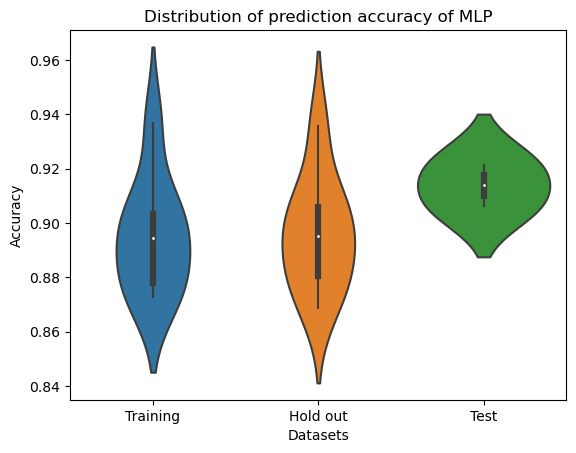

In [3]:

start_time = time.time() 

# ------------------- Train the MLP model -------------------
polya_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, alpha=1e-4,
                    solver='adam', verbose=10, random_state=random_seed, shuffle=True,
                    learning_rate_init=0.001)

held_out_polya = sp.csr_matrix((0, 150))
held_out_polya_bg = sp.csr_matrix((0, 150)) 
random.seed(random_seed)
train_list = PE_sheet.loc[PE_sheet['GSE'].isin(random.sample(PE_sheet['GSE'].unique().tolist(), 8))]
num_srr = {GSE: group_gse_lst.shape[0] for (GSE, group_gse_lst) in train_list.groupby('GSE')}
# initialize the sparse matrix 
training_batch = sp.csr_matrix((0, 150))

training_data_acc_list_during_train = []

# we group by GSE, then loop through SRRs to get the polya seq
for i, (GSE, group_gse_lst) in enumerate(train_list.groupby('GSE')):
    SRR_lst = group_gse_lst['SRR']
    num_held_out = 1000//len(SRR_lst)
    
    for SRR in SRR_lst:
        # The 30 bases are defined according to R2. So, they should always be polyA

        polya_path = os.path.join(
            parent_dir, "process_data", "frag_len_dist", GSE, SRR, "priming_site_seqs", "polya_seq.txt")
        bg_path = os.path.join(
            parent_dir, "process_data", "frag_len_dist", GSE, SRR, "priming_site_seqs", "polya_bg_seq.txt")

        # get polya and bg seq
        # we want to make sure the polya seq has a polyA six mer with at most one mismatch
        polya_batch = encoder.fit_transform([list(x.strip()) for x in open(polya_path).readlines() if len(x.strip()) == 30 and regex.search("A(" + 'A' * (snr_len-2)+ "){s<=" + str(snr_mismatch) +"}A", x.strip())])

        # polya_batch = encoder.fit_transform([list(x.strip()) for x in open(polya_path).readlines() if len(x.strip()) == 30])
        
        # if we do not have enough data, then skip this SRR
        if polya_batch.shape[0] < num_held_out * 2:
            print("Not enough training examples for", GSE, SRR)
            continue
        
        bg_batch = encoder.fit_transform([list(x.strip()) for x in open(bg_path).readlines() if len(x.strip()) == 30])
        
        # if we do not have enough data, then skip this SRR
        if bg_batch.shape[0] < num_held_out * 2:
            print("Not enough background examples for", GSE, SRR)
            continue
        
        # num_held_out = min(math.ceil(polya_batch.shape[0] * 0.1), 20)
        num_train_fg = polya_batch.shape[0]
        num_train_bg = min(num_train_fg, bg_batch.shape[0])

        polya_batch = polya_batch[np.random.randint(0, polya_batch.shape[0], size = num_train_fg), : ]
        bg_batch = bg_batch[np.random.randint(0, bg_batch.shape[0], size = num_train_bg), : ]
        
        fg_shuf_id = np.arange((num_train_fg+num_train_bg-num_held_out*2))
        np.random.shuffle(fg_shuf_id)

        # build training data
        train_polya = sp.vstack([
            polya_batch[num_held_out:],
            bg_batch[num_held_out:]
        ])[fg_shuf_id,:]
        
        del polya_batch
        del bg_batch
        
        label_polya = np.hstack([
            np.ones(num_train_fg - num_held_out), 
            np.zeros(num_train_bg - num_held_out)
        ])[fg_shuf_id]
        
        # fit the model using the data from this SRR
        polya_mlp.partial_fit(
            train_polya,
            label_polya,
            classes=[0,1]
        )
        acc = accuracy_score(label_polya, 
            polya_mlp.predict(train_polya))
        training_data_acc_list_during_train.append(acc)
        # get the accuracy on the held out data
        print("Accuracy:", acc)


print("The mean accuracy on the training datasets is:", sum(training_data_acc_list_during_train)/len(training_data_acc_list_during_train))

# ------------------- Test the model(partI)-------------------
# Test the model on the training sets and held out sets for each srr
random.seed(random_seed)
train_list = PE_sheet.loc[PE_sheet['GSE'].isin(random.sample(PE_sheet['GSE'].unique().tolist(), 8))]
num_srr = {GSE: group_gse_lst.shape[0] for (GSE, group_gse_lst) in train_list.groupby('GSE')}
# initialize the sparse matrix 
training_batch = sp.csr_matrix((0, 150))
held_out_polya = sp.csr_matrix((0, 150))
held_out_polya_bg = sp.csr_matrix((0, 150)) 

training_data_acc_list = []
held_out_data_acc_list = []

# we group by GSE, then loop through SRRs to get the polya seq
for i, (GSE, group_gse_lst) in enumerate(train_list.groupby('GSE')):
    SRR_lst = group_gse_lst['SRR']
    num_held_out = 1000//len(SRR_lst)
    # inital the matrix/list for each GSE
    train_polya_per_gse = sp.csr_matrix((0, 150))
    train_label_per_gse = np.array([])

    held_out_polya_per_gse = sp.csr_matrix((0, 150))
    held_out_label_per_gse = np.array([])

    for SRR in SRR_lst:
        # The 30 bases are defined according to R2. So, they should always be polyA
        polya_path = os.path.join(
            parent_dir, "process_data", "frag_len_dist", GSE, SRR, "priming_site_seqs", "polya_seq.txt")
        bg_path = os.path.join(
            parent_dir, "process_data", "frag_len_dist", GSE, SRR, "priming_site_seqs", "polya_bg_seq.txt")

        # get polya and bg seq
        # we want to make sure the polya seq has a polyA six mer with at most one mismatch
        polya_batch = encoder.fit_transform([list(x.strip()) for x in open(polya_path).readlines() if len(x.strip()) == 30 and regex.search("A(" + 'A' * (snr_len-2)+ "){s<=" + str(snr_mismatch) +"}A", x.strip())])
        
        # polya_batch = encoder.fit_transform([list(x.strip()) for x in open(polya_path).readlines() if len(x.strip()) == 30])
        
        # if we do not have enough data, then skip this SRR
        if polya_batch.shape[0] < num_held_out * 2:
            print("Not enough training examples for", GSE, SRR)
            continue
        
        bg_batch = encoder.fit_transform([list(x.strip()) for x in open(bg_path).readlines() if len(x.strip()) == 30])
        
        # if we do not have enough data, then skip this SRR
        if bg_batch.shape[0] < num_held_out * 2:
            print("Not enough background examples for", GSE, SRR)
            continue
        
        # num_held_out = min(math.ceil(polya_batch.shape[0] * 0.1), 20)
        num_train_fg = polya_batch.shape[0]
        num_train_bg = min(num_train_fg, bg_batch.shape[0])

        polya_batch = polya_batch[np.random.randint(0, polya_batch.shape[0], size = num_train_fg), : ]
        bg_batch = bg_batch[np.random.randint(0, bg_batch.shape[0], size = num_train_bg), : ]

        # append held out data
        polya_held_out = polya_batch[:num_held_out,]
        bg_held_out = bg_batch[:num_held_out,]
        
        fg_shuf_id = np.arange((num_train_fg+num_train_bg-num_held_out*2))
        np.random.shuffle(fg_shuf_id)

        # build training data
        train_polya = sp.vstack([
            polya_batch[num_held_out:],
            bg_batch[num_held_out:]
        ])[fg_shuf_id,:]
        
        del polya_batch
        del bg_batch
        
        label_polya = np.hstack([
            np.ones(num_train_fg - num_held_out), 
            np.zeros(num_train_bg - num_held_out)
        ])[fg_shuf_id]

        # group the train data by gse
        train_polya_per_gse = sp.vstack([train_polya_per_gse, train_polya])
        train_label_per_gse = np.hstack([train_label_per_gse, label_polya])

        #group the held out data by gse
        held_out_label_per_gse = np.hstack([held_out_label_per_gse, np.hstack([np.ones(num_held_out), np.zeros(num_held_out)])])
        held_out_polya_per_gse = sp.vstack([held_out_polya_per_gse, sp.vstack([polya_held_out, bg_held_out])])

    # accuracy for classification on the training data
    acc_train = accuracy_score(train_label_per_gse, 
        polya_mlp.predict(train_polya_per_gse))
    training_data_acc_list.append(acc_train)
    print("Accuracy on training data:", acc_train)

    # accuracy for classification on the held out data
    acc_held_out = accuracy_score(held_out_label_per_gse, 
        polya_mlp.predict(held_out_polya_per_gse))
    held_out_data_acc_list.append(acc_held_out)
    print("Accuracy on held out data:", acc_held_out)

print("The mean accuracy on the training datasets is:", sum(training_data_acc_list)/len(training_data_acc_list))
print("The mean accuracy on the held out datasets is:", sum(held_out_data_acc_list)/len(held_out_data_acc_list))

# --------- Test the model (partII)-----------------
# we also want to test the accuracy on test datasets
# we read in the test data
random.seed(random_seed)
test_list = PE_sheet.loc[~PE_sheet['GSE'].isin(random.sample(PE_sheet['GSE'].unique().tolist(), 8))]
test_acc_list = []
# we group by GSE, then loop through SRRs to get the polya seq
for i, (GSE, group_gse_lst) in enumerate(test_list.groupby('GSE')):
    SRR_lst = group_gse_lst['SRR']

    test_polya_per_gse = sp.csr_matrix((0, 150))
    test_label_per_gse = np.array([])
    
    for SRR in SRR_lst:
        # The 30 bases are defined according to R2. So, they should always be polyA

        polya_path = os.path.join(
            parent_dir, "process_data", "frag_len_dist", GSE, SRR, "priming_site_seqs", "polya_seq.txt")
        bg_path = os.path.join(
            parent_dir, "process_data", "frag_len_dist", GSE, SRR, "priming_site_seqs", "polya_bg_seq.txt")

        # get polya and bg seq
        # we want to make sure the polya seq has a polyA six mer with at most one mismatch
        polya_batch = encoder.fit_transform([list(x.strip()) for x in open(polya_path).readlines() if len(x.strip()) == 30 and regex.search("A(" + 'A' * (snr_len-2)+ "){s<=" + str(snr_mismatch) +"}A", x.strip())])
        # polya_batch = encoder.fit_transform([list(x.strip()) for x in open(polya_path).readlines() if len(x.strip()) == 30])
        
        # if we do not have enough data, then skip this SRR
        if polya_batch.shape[0] < num_held_out * 2:
            print("Not enough training examples for", GSE, SRR)
            continue
        
        bg_batch = encoder.fit_transform([list(x.strip()) for x in open(bg_path).readlines() if len(x.strip()) == 30])
        
        # if we do not have enough data, then skip this SRR
        if bg_batch.shape[0] < num_held_out * 2:
            print("Not enough background examples for", GSE, SRR)
            continue
        
        # build training data
        test_polya = sp.vstack([
            polya_batch[random.sample(range(polya_batch.shape[0]), min(polya_batch.shape[0], bg_batch.shape[0])), : ],
            bg_batch[random.sample(range(bg_batch.shape[0]), min(polya_batch.shape[0], bg_batch.shape[0])), : ]
        ])
        label_polya = np.hstack([
            np.ones(min(polya_batch.shape[0], bg_batch.shape[0])), 
            np.zeros(min(polya_batch.shape[0], bg_batch.shape[0]))
        ])

        del polya_batch
        del bg_batch

        # group the test data by gse
        test_polya_per_gse = sp.vstack([test_polya_per_gse, test_polya])
        test_label_per_gse = np.hstack([test_label_per_gse, label_polya])
        
        
    # get the accuracy on the held out data
    acc_scores = accuracy_score(
        test_label_per_gse, 
        polya_mlp.predict(test_polya_per_gse))
    test_acc_list.append(acc_scores)
    print("Accuracy:", acc_scores)


print("The mean accuracy on the test datasets is:", sum(test_acc_list)/len(test_acc_list))

# outdir = '/fs/nexus-projects/sc_frag_len/nextflow/workflow_output/models/mlp_model'
accuracy_file_path = os.path.join(outdir, "accuracy_3_lists.pkl")
joblib.dump([training_data_acc_list, held_out_data_acc_list, test_acc_list], accuracy_file_path)

[training_data_acc_list, held_out_data_acc_list, test_acc_list]= joblib.load(accuracy_file_path, "rb")
# accuracy log
acc_dict = {
    "training_data_acc_list": training_data_acc_list,
    "held_out_data_acc_list": held_out_data_acc_list,
    "test_acc_list": test_acc_list
}
with open(os.path.join(outdir, 'acc_list_log.txt'),'w') as file:
    file.write(f"The time used for training the model is: {time.time() - start_time} seconds\n")
    for l_name, acc_list in acc_dict.items():
        file.write( '---------'+ "\n")
        file.write(l_name + "\n")
        for acc_num in acc_list:
                file.write(str(acc_num)+"\n")
file.close()

#------------------- Save the model -------------------
model_pkl_path = os.path.join(outdir, f'mlp.pkl')
joblib.dump(polya_mlp, model_pkl_path)

# Combine the lists into a single dataset with corresponding labels
data = training_data_acc_list + held_out_data_acc_list + test_acc_list
labels = ['Training'] * len(training_data_acc_list) + ['Hold out'] * len(held_out_data_acc_list) + ['Test'] * len(test_acc_list)
print(f"training_data_acc_list: {training_data_acc_list}")
print(f"held_out_data_acc_list: {held_out_data_acc_list}")
print(f"test_acc_list: {test_acc_list}")
# Create a DataFrame for easier plotting with Seaborn
df = pd.DataFrame({'Data': data, 'Datasets': labels})

# Create the violin plot
sns.violinplot(x='Datasets', y='Data', data=df)
plt.title("Distribution of prediction accuracy of MLP")
plt.ylabel('Accuracy')
plt.savefig(os.path.join(outdir, f"violin_plot_per_gse.png"),dpi = 300)
plt.show()


        

